In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

## Data

In [5]:
train_section = pd.read_table("Article-Bias-Prediction-main/data/randomtraindata.csv", sep=',', index_col=0)
test_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)
val_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)


In [6]:
train_section.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,coronavirus,The Guardian,0,https://www.theguardian.com/world/2020/mar/26/...,US coronavirus stimulus checks: are you eligib...,2020-03-26,Lauren Aratani,Most taxpayers will get a check from the $ 2tn...,Most taxpayers will get a check from the $2tn ...,www.theguardian.com,left,IBgtqEHUEcjyMriR
1,healthcare,Washington Times,2,http://www.washingtontimes.com/news/2013/feb/1...,After Obamacare health exchange deadline passe...,2013-02-16,Tom Howell Jr.,The backbone of President Obama ’ s health car...,The backbone of President Obama’s health care ...,www.washingtontimes.com,right,LC3zdsbACLILzBhY
2,politics,National Review,2,https://www.nationalreview.com/2019/08/the-doj...,The DOJ Will Not Prosecute James Comey over Tr...,2019-08-03,"Andrew C. Mccarthy, John Mccormack, Michael Br...",Then-FBI Director James Comey testifying on Ca...,Then-FBI Director James Comey testifying on Ca...,www.nationalreview.com,right,W084H19Vniu1Z24f
3,media_bias,NPR Online News,1,https://www.npr.org/2018/08/27/642356784/fox-n...,Fox News Hasn't Always Shared Robert Driscoll'...,2018-08-27,David Folkenflik,Fox News Has n't Always Shared Robert Driscoll...,Fox News Hasn't Always Shared Robert Driscoll'...,www.npr.org,center,Lcvv69hlu4J5Foc3
4,trade,Bloomberg,1,https://www.bloomberg.com/news/articles/2019-0...,"Wilbur Ross Says U.S., China ‘Miles and Miles’...",2019-01-24,"Brendan Murray, Andrew Mayeda",LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,www.bloomberg.com,center,ZW7MmqXMtiJgL6jY


In [7]:
train_section.iloc[10].content

'The real fake-out is that the Left is capable of honestly policing fake news .\nLast week , Harvard released a new research guide on “ fake news . ”\n“ Fake news , ” of course , is the source of all evil , according to the Left . It ’ s only thanks to lies that Donald Trump was elected ! Instead of targeting stories that are completely false , however , the Left applies the label of “ fake news ” to outlets that report factual stories but draw political conclusions from them — in other words , they call everything with which they disagree “ fake news . ”\nWhich means that their talk of “ fake news ” is actually fake news .\nOf course , the largest “ fake news ” item of all is that “ objective ” news sources aren ’ t biased in their coverage . They obviously are , and it ’ s why conservatives have warmed to President Trump ’ s labeling left-leaning outlets such as CNN “ fake news ” even if CNN isn ’ t actually reporting anything factually false but merely drawing convenient leftist inf

In [8]:
# train_section = train_section[:20000]
# val_section = train_section[:4000]

# test_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)
# val_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)


<AxesSubplot:>

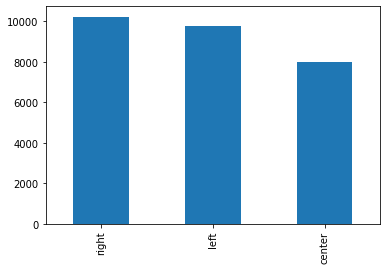

In [9]:
fig, ax = plt.subplots()
train_section["bias_text"].value_counts().plot(ax=ax, kind="bar")

<AxesSubplot:>

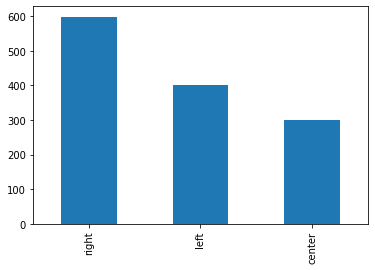

In [10]:
fig, ax = plt.subplots()
val_section["bias_text"].value_counts().plot(ax=ax, kind="bar")

<AxesSubplot:>

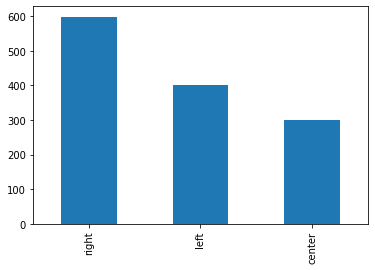

In [11]:
fig, ax = plt.subplots()
test_section["bias_text"].value_counts().plot(ax=ax, kind="bar")

## Hyperparameters

In [12]:
MAX_LEN = 512
nepochs = 20
nbatch = 16

In [13]:
data_dir = "./data"
log_dir = f"{data_dir}/experiments/logs"
save_path = f"{data_dir}/experiments/XLNetmodellarge"
cache_path_train = f"{data_dir}/cache/XLNetmodellarge.train"
cache_path_test = f"{data_dir}/cache/XLNetmodellarge.test"

## Transforming Data

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = np.asarray(le.fit_transform(train_section['bias_text']))
val_labels = np.asarray(le.transform(val_section['bias_text']))

In [15]:
# le.inverse_transform(val_labels)[:20]

In [16]:
len(np.unique(train_labels))

3

In [17]:
tokenizer_transformer = XLNetTokenizer.from_pretrained('xlnet-large-cased')

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [18]:

def create_input_array(df, tokenizer):
    sentences = df.content.values

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=MAX_LEN,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='tf',  # Return tf tensors.
            )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        token_type_ids.append(encoded_dict['token_type_ids'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    token_type_ids = tf.convert_to_tensor(token_type_ids)


    return input_ids, attention_masks, token_type_ids
#     return input_ids, attention_masks



In [19]:
train_inputs = [create_input_array(train_section, tokenizer=tokenizer_transformer)]
val_inputs = [create_input_array(val_section, tokenizer=tokenizer_transformer)]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
def convert_inputs_to_tf_dataset(inputs):
    # args.max_seq_len = 256
    ids = inputs[0][0]
    masks = inputs[0][1]
    token_types = inputs[0][2]

    ids = tf.reshape(ids, (-1, MAX_LEN))
    print("Input ids shape: ", ids.shape)
    masks = tf.reshape(masks, (-1, MAX_LEN))
    print("Input Masks shape: ", masks.shape)
    token_types = tf.reshape(token_types, (-1, MAX_LEN))
    print("Token type ids shape: ", token_types.shape)

    ids=ids.numpy()
    masks = masks.numpy()
    token_types = token_types.numpy()
#     return[ids]
#     return [ids, masks, token_types]
    return [ids, masks]

In [21]:
train_data = convert_inputs_to_tf_dataset(train_inputs)
val_data = convert_inputs_to_tf_dataset(val_inputs)

Input ids shape:  (27978, 512)
Input Masks shape:  (27978, 512)
Token type ids shape:  (27978, 512)
Input ids shape:  (1300, 512)
Input Masks shape:  (1300, 512)
Token type ids shape:  (1300, 512)


In [22]:
train_data

[array([[ 1073, 11515,    53, ...,  4094,     4,     3],
        [   32, 21978,    20, ...,   120,     4,     3],
        [ 1019,    13, 16580, ...,    71,     4,     3],
        ...,
        [  122,   132,    39, ...,    17,     4,     3],
        [ 9874,    17,    14, ...,    17,     4,     3],
        [   67,    18,   307, ...,  6046,     4,     3]], dtype=int32),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=int32)]

In [23]:
model = TFXLNetForSequenceClassification.from_pretrained("xlnet-large-cased", num_labels=len(np.unique(train_labels)))


Downloading:   0%|          | 0.00/761 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-large-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-large-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.summary()

Model: "tfxl_net_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFXLNetMainLaye multiple                  360268800 
_________________________________________________________________
sequence_summary (TFSequence multiple                  1049600   
_________________________________________________________________
logits_proj (Dense)          multiple                  3075      
Total params: 361,321,475
Trainable params: 361,321,475
Non-trainable params: 0
_________________________________________________________________


In [25]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(x = train_data, 
          y = train_labels,
          validation_data= (val_data, val_labels), 
          epochs = nepochs, 
          batch_size = 5)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5596/5596 [==============================] - 4683s 833ms/step - loss: 1.1043 - accuracy: 0.3592 - val_loss: 1.0593 - val_accuracy: 0.4246
Epoch 2/20
5596/5596 [==============================] - 4688s 838ms/step - loss: 1.0882 - accuracy: 0.3855 - 

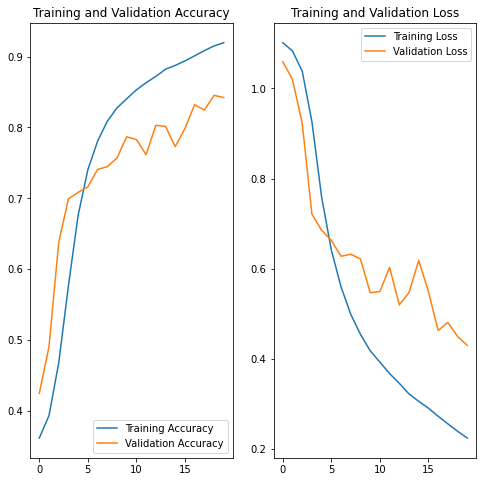

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nepochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.show()
plt.savefig('xlnetlargebinary20.jpg')

In [27]:
xlnetmodeldata = pd.DataFrame(list(zip(acc, val_acc, loss, val_loss)),
               columns =['Accuracy', 'ValAccuracy', 'Loss', 'Val_loss'])
xlnetmodeldata.head()

,Accuracy,ValAccuracy,Loss,Val_loss
0,0.361498,0.424615,1.101629,1.059340
1,0.393202,0.490769,1.083044,1.019700
2,0.467474,0.637692,1.038630,0.923115
3,0.576596,0.699231,0.926187,0.721041
4,0.676067,0.708462,0.758962,0.685202


In [29]:
xlnetmodeldata.to_csv("xlnetmodeldata.csv", sep='\t')

In [ ]:
test_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)
test_section.shape

In [ ]:
test_labels = np.asarray(le.transform(test_section['bias_text']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer)]
test_data = convert_inputs_to_tf_dataset(test_inputs)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_data, test_labels, batch_size=5)
print("test loss, test acc:", results)


In [ ]:
testmodel = TFXLNetForSequenceClassification.from_pretrained("data/experiments/XLNetmodel1", num_labels=len(np.unique(train_labels)))


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

testmodel.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# predict probabilities for test set
test_probs = testmodel.predict(test_data, batch_size= 1, verbose=0)

In [ ]:
test_probs = test_probs["logits"]

In [ ]:
test_classes = np.argmax(test_probs, axis = 1)

In [ ]:
test_classes

In [ ]:
test_labels

In [ ]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % f1)
 

In [ ]:
train_section.to_csv("train_dataset.csv", sep='\t')
val_section.to_csv("val_dataset.csv", sep='\t')
test_section.to_csv("test_dataset.csv", sep='\t')

In [30]:
model.save_pretrained(save_path)

In [ ]:
tf.keras.backend.clear_session()